In [1]:
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from os import listdir, makedirs
from os.path import exists
import matplotlib.pyplot as plt
from glob import glob

data_root = './data/'
BATCH = 30
log = True
model_name = 'model'
load_model_path = 'model.h5'
debug = False

In [2]:
# collect data folders from data root
def get_data_folders(root_path):
    return glob(root_path+'*')

# collect data lines from csv file
def get_lines_from_file(file_path, header=False):
    lines = []
    with open('./'+file_path) as csvfile:
        reader = csv.reader(csvfile)
        if header:
            next(reader, None)
            print ('skipping header')
        for line in reader:
            lines.append(line)
    return lines

# for each folder collect lines from csv file
def collect_all_data(data_folders, debug):
    all_lines = []
    for folder in data_folders:
        file_path = folder+'/driving_log.csv'
        if folder.split('/')[-1] == 'data1':
            header = True
        else:
            header = False
        if debug:
            lines = get_lines_from_file(file_path, header=header)[:30]
        else:
            lines = get_lines_from_file(file_path, header=header)
        all_lines.extend(lines)
    return all_lines
        
        

# yield batch_size images (rgb)
def my_generator(lines, batch_size=BATCH):
    correction = 0.2
    num_of_samples = len(lines)
    
    # each line in csv file holds path to 3 imags, therefore -
    lines_in_batch = batch_size//3
    while 1:
        for offset in range(0, num_of_samples, lines_in_batch):
            images, labels = [], []
            
            batch_samples = lines[offset:offset+lines_in_batch]
            for line in batch_samples:
                
                # for each line in file, collect 3 images (center, right & left camera)
                for i in range(3):
                    
                    filename = '/'.join(line[i].split('/')[-4:])                 
                    try:
                        image = cv2.imread(filename)
                        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                    except:
                        print('could not read img in path:', filename)
                    images.append(image)
                    
                    # correct angle according to camera perspective
                    if i == 0:
                        measur = float(line[3])
                    elif i == 1:
                        measur = float(line[3])+correction
                    elif i == 2:
                        measur = float(line[3])-correction
                    
                    labels.append(measur)
                    
            X_train = np.array(images)
            y_train = np.array(labels)
            yield X_train, y_train


In [3]:
# call generator to get images. for each image, plot as is and cropped
def plot_images(generator, images_to_plot=6):
    X_train, y_train = next(generator)
    num_to_plot = min(images_to_plot, len(X_train))
    print('plotting {0} images as is + {0} cropped'.format(num_to_plot))
    fig = plt.figure(figsize=(24, 10))
    for i in range(num_to_plot):
        ax1 = fig.add_subplot(3, images_to_plot, i*3+1)
        ax1.set_title("'#{} as is. Ang={}".format(i, str(y_train[i])[:6]))
        ax1.set_xlim([0, 320])
        ax1.set_ylim([160, 0])
        plt.imshow(X_train[i], interpolation="nearest")
        
        ax2 = fig.add_subplot(3, images_to_plot, i*3+2)
        ax2.set_title("'#{} cropped. Ang={}".format(i, str(y_train[i])[:6]))
        ax2.set_xlim([0, 320])
        ax2.set_ylim([100, 0])
        plt.imshow(X_train[i][50:150,:], interpolation="nearest")
    plt.tight_layout()   
    plt.show()
    plt.close(fig)

In [4]:
data_folders = get_data_folders(data_root)
print('{} data folders in data root'.format(len(data_folders)))
lines_from_file = collect_all_data(data_folders, debug=debug)
print ('# of lines collected:',len(lines_from_file))

5 data folders in data root
skipping header
# of lines collected: 26074


In [5]:
# plot data histogram 
def plot_hist(float_list, title=''):
    from matplotlib.ticker import FuncFormatter
    x = np.array(float_list)
    plt.clf()
    fig = plt.figure(figsize=(16, 8))
    n, bins, patches = plt.hist(x, 30, facecolor='green', normed=1)
    
    for item in patches:
        item.set_height(item.get_height()/sum(n))
    
    mean = str(np.mean(x))[:5]
    std = str(np.std(x))[:5]
    plt.xlabel('Angles')
    if title == '':
        title = 'Angles dist'
    plt.title('{}. total samps={}, Mean={}, std={}'.format(title, len(float_list), mean, std))
    plt.axis([np.min(x)-0.1, np.max(x)+0.1, 0, 0.5])
    formatter = FuncFormatter(to_percent)
    # Set the formatter
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

    plt.show()

# change histogram y axis from quantity to percent
def to_percent(y, position):
    from matplotlib import rcParams
    s = str(100 * y)
    if rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

# collect all angles from list of lines
def collect_all_angs(all_lines):
    angs = []
    for line in all_lines:
        angs.append(float(line[3]))
    return angs

In [6]:
if debug:
    num_of_samps = len(lines)*8//10
    train_samples, validation_samples = lines_from_file[:num_of_samps], lines_from_file[num_of_samps:]
else:
    train_samples, validation_samples = train_test_split(lines_from_file, test_size=0.15)
print ('# of samples in train set:', len(train_samples))
print ('# of samples in validation set:',len(validation_samples))

# of samples in train set: 22162
# of samples in validation set: 3912


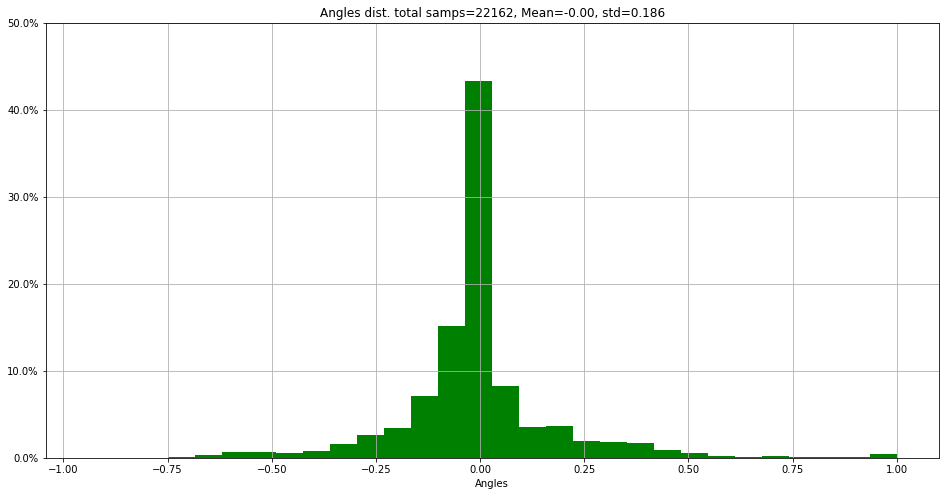

In [7]:
angs1 = collect_all_angs(train_samples)
plot_hist(angs1)

initial dataset size:  22162
total samples after re_dist: 79594


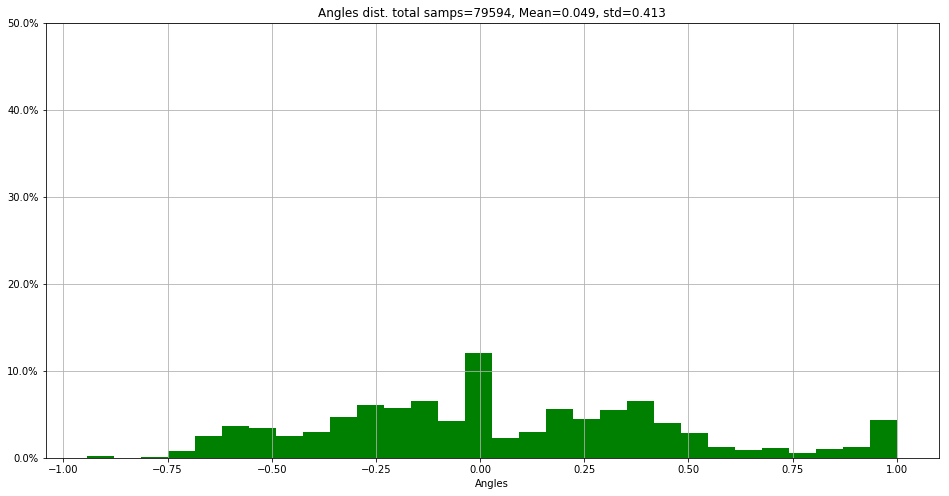

In [8]:
#change distribution of lines in the dataset to increase representation of bigger positive/negative angles (abs value)
def re_dist_dataset(all_lines, angs, initial_thresh=0.1, initial_multiplier = 2):
    print('initial dataset size: ', len(all_lines))
    for i in range(len(angs)):
        if abs(angs[i]) > initial_thresh:
            multiplier = initial_multiplier*int(abs(angs[i]/initial_thresh))
            for j in range(multiplier-2):
                all_lines.append(all_lines[i])
    print('total samples after re_dist:', len(all_lines))
    return all_lines

lines = re_dist_dataset(train_samples, angs1, initial_thresh=0.05, initial_multiplier = 2)
redist_angs = collect_all_angs(lines)
plot_hist(redist_angs)

input shape: (160, 320, 3) 

plotting 6 images as is + 6 cropped


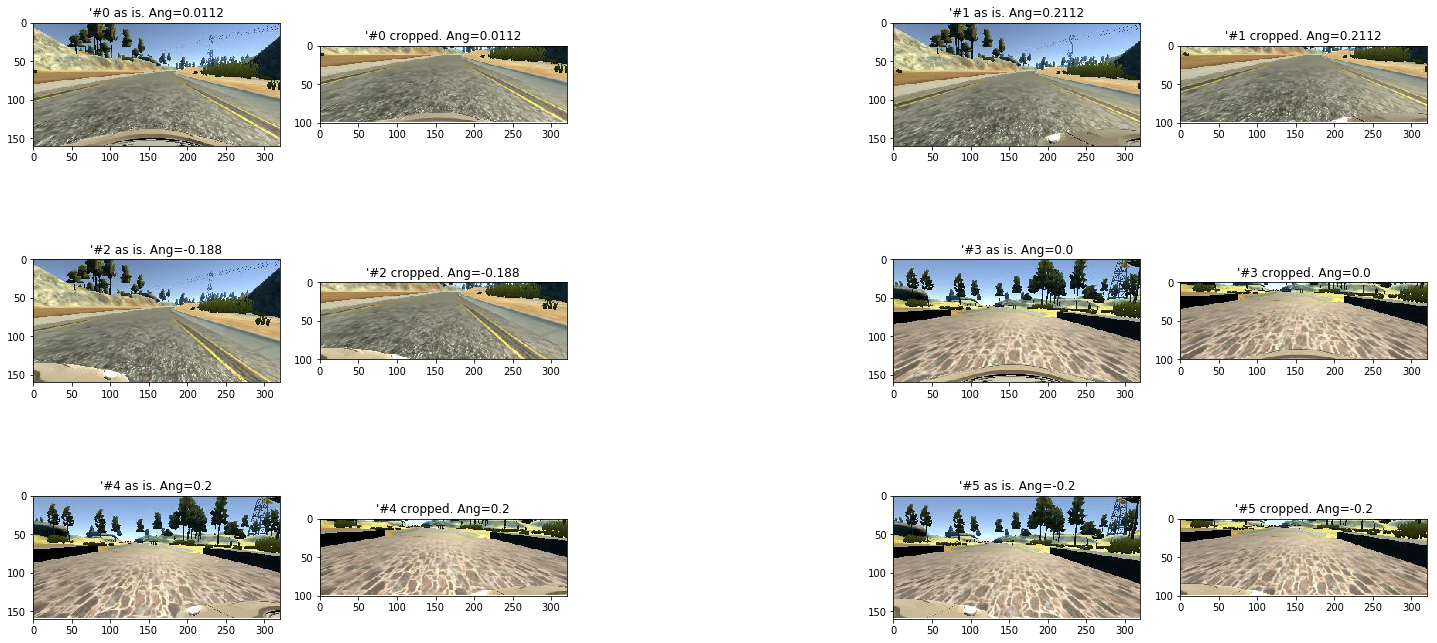

In [9]:
get_data = my_generator(train_samples, batch_size=BATCH)
X_train, y_train = next(get_data)
Input_shape = X_train[0].shape
print('input shape:', Input_shape, '\n')
plot_images(get_data)

ploting 6 cropped images


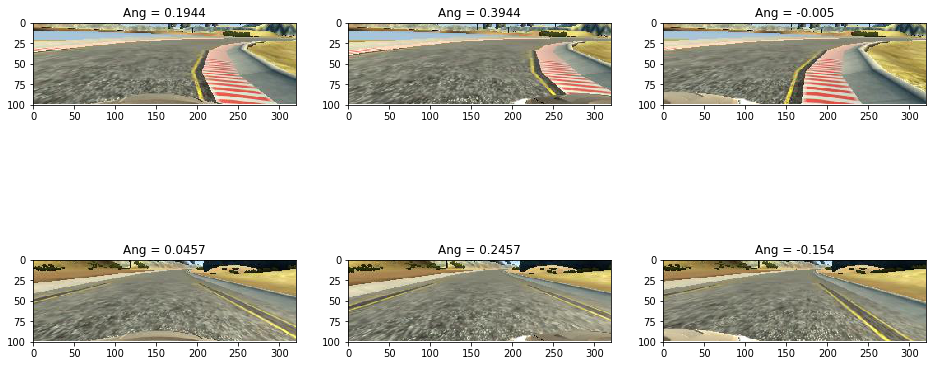

In [12]:
#some more plotting
plot = True
if plot:
    images_to_plot = 6
    print('ploting', images_to_plot, 'cropped images')
    fig = plt.figure(figsize=(16, 8))
    for i in range(images_to_plot):
        ax1 = fig.add_subplot(2, images_to_plot/2, i + 1)
        ax1.set_title("Ang = {0}".format(str(y_train[i])[:6]))
        ax1.set_xlim([0, 320])
        ax1.set_ylim([100, 0])
        plt.imshow(X_train[i][50:150,:], interpolation="nearest")
    plt.show()
    plt.close(fig)

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout, Cropping2D
from keras import optimizers, metrics
from keras.models import load_model

load_model_path='model.h5'

def get_model(Input_shape):
    model = Sequential()
    model.add(Cropping2D(cropping=((50,10),(0,0)), input_shape=Input_shape))
    model.add(Lambda(lambda x: (x/255.0)-0.5))
    model.add(Conv2D(24, kernel_size=(5, 5), activation="relu", padding='same'))
    model.add(MaxPooling2D(padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(36, kernel_size=(5, 5), activation="relu", padding='same'))
    model.add(MaxPooling2D(padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(48, kernel_size=(5, 5), activation="relu", padding='same'))
    model.add(MaxPooling2D(padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'))
    model.add(MaxPooling2D(padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, kernel_size=(1, 1), activation="relu", padding='same'))
    model.add(MaxPooling2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

# either load existing model or initialize a new model
if load_model_path != '':
    model = load_model(load_model_path)
    print('model laoded from file', load_model_path)
else:
    print ('initializing model')
    model = get_model(Input_shape)

adagrad = optimizers.Adagrad(lr=0.001, epsilon=1e-08, decay=1e-06)
model.compile(loss='mse', optimizer=adagrad, metrics=['mae'])

Using TensorFlow backend.


model laoded from file model.h5


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 100, 320, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 320, 24)      1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 160, 24)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 160, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 160, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 80, 36)        0         
__________

In [15]:
# create log, tensorboard & checkpoints directories & paths (if log == True)
def create_dir(path):
    if not exists(path):
        try:
            makedirs(path)
            print('created directory:', path)
        except:
            print('could not create directory:', path, 'exiting')
            pass
    else:
        print('path already exists', path)

if log:
    from datetime import datetime
    from keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
    log_root = '.'
    FORMAT = '%Y%m%d_%H%M%S'
    log_name = '%s_%s' % (model_name, datetime.now().strftime(FORMAT))
    create_dir(log_root+'/logs/')
    create_dir(log_root+'/TB/')
    create_dir(log_root+'/Checkpoints/')
    log_name = '%s_%s' % (model_name, datetime.now().strftime(FORMAT))
    log_path = '%s%s%s' % (log_root+'/logs/',log_name, '.csv')
    TB_path = '%s%s%s' % (log_root+'/TB/',log_name,'/')
    CP_path = '%s%s_%s' % (log_root+'/Checkpoints/',log_name, 'weights.h5')
    
    print('logging to path:', log_path)
    print('tensorboarding to path:', TB_path)
    print('checkpointing to path:', CP_path)


path already exists ./logs/
path already exists ./TB/
path already exists ./Checkpoints/
logging to path: ./logs/model_20171207_192349.csv
tensorboarding to path: ./TB/model_20171207_192349/
checkpointing to path: ./Checkpoints/model_20171207_192349_weights.h5


In [ ]:
# training the model
EPOCHs = 6
steps_per_epoch = int(len(train_samples)/BATCH*3)
validation_steps=int(len(validation_samples)/BATCH*3)
print('steps_per_epoch:', steps_per_epoch, 'validation_steps:', validation_steps)
if log:
    # creating logs, tensorboard files & saving model
    csv_logger = CSVLogger(log_path, append=True, separator=';')
    tbcallback = TensorBoard(log_dir=TB_path, histogram_freq=0)
    checkpointer = ModelCheckpoint(filepath=CP_path, verbose=1, save_best_only=True)

    history_object = model.fit_generator(generator=my_generator(train_samples, batch_size=BATCH),
                        steps_per_epoch=steps_per_epoch, validation_data=my_generator(validation_samples), 
                        validation_steps=validation_steps, epochs=EPOCHs, verbose=1, 
                                         callbacks=[csv_logger, tbcallback, checkpointer])
else:
    history_object = model.fit_generator(generator=my_generator(train_samples, batch_size=BATCH),
                        steps_per_epoch=steps_per_epoch, validation_data=my_generator(validation_samples), 
                        validation_steps=validation_steps, epochs=EPOCHs, verbose=1)
print('done training.')

In [ ]:
# manually save model if needed
save_path='model' + str(history_object.history['val_loss'][len(history_object.history['val_loss'])-1])[:6]+ '.h5'
model.save(save_path)
print('model saved to', save_path)

In [ ]:
# plot loss & val_loss for each epoch 
def plot_loss(data_to_plot):
    fig = plt.figure(figsize=(16, 8))
    plt.plot(data_to_plot.history['loss'])
    plt.plot(data_to_plot.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    plt.close()

In [ ]:
plot_loss(history_object)